# Setup
For now we'll just be importing a few things we'll definitely need 

In [1]:
import geopandas as gp
import pandas as pd

## GTFS Import: Where are our public transport stops?

Importing the GTFS feed with all the stops and stations to display them on a map. This step will allow a first quality assesment of the data. As GTFS is basically a relational database made up of various comma-separated text files, we'll first need to make sure pandas and geopandas can read them properly. The first file we'll look at is `stops.txt`, because it is the only that actually contains geo-referenced data, the stop locations. All the other files in the GTFS feed are referencing these stops to create relations between them

In [2]:
stops_df = pd.read_csv("2022-07-26_RNV_GTFS_Schedule\\stops.txt")
stops_df.to_csv("stops.csv")

Now we have the GTFS stop file as a .csv. we need to make sure the columns stop_lon, and stop_lat are converted to a format that geopandas can work with

In [3]:
stops_gdf = gp.GeoDataFrame(stops_df, geometry=gp.points_from_xy(stops_df.stop_lon, stops_df.stop_lat))
stops_gdf.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,platform_code,geometry
0,11601,Bad Dürkheim Bahnhof,49.461528,8.170429,0,1,POINT (8.17043 49.46153)
1,13401,Bad Dürkheim Ost,49.463490,8.185206,0,1,POINT (8.18521 49.46349)
2,13402,Bad Dürkheim Ost,49.463420,8.184254,0,2,POINT (8.18425 49.46342)
3,51501,Dossenheim Bahnhof,49.448191,8.670171,0,1,POINT (8.67017 49.44819)
4,51502,Dossenheim Bahnhof,49.448553,8.669533,0,2,POINT (8.66953 49.44855)


## Mapping our Dataset
Let's try and plot this

### A Plot on simple Axes

<AxesSubplot:>

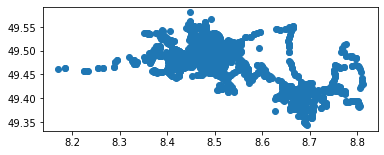

In [4]:
stops_gdf.plot()

Well we do have a sensible plot, but we might need some more data to really read it, for that we'll import folium to give us some more map options.

### Putting Our Dataset on a Map

In [5]:
import folium
#creating the map from Open Street Maps
map = folium.Map(location = [49.46531, 8.54317], tiles='OpenStreetMap' , zoom_start = 11)
#and adding out geopandas frame

stops_gdf.explore("platform_code", m=map)


c:\Users\chwiggy\anaconda3\envs\PublicTransport\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We have a map. This won't render on GitHub however. To see what i've been doing, download the `stops_map.html` file from the repository and open it in your browser.

This however took me some fiddling, because at first I did not have the right geopandas version installed for the `.explore()` method to work. And then I thought i had some wild crs issues, that i valiantly tried to fix, when i had just accidentally swapped the `x,y` to `stop_lon, stop_lat` tranformation. This caused two issues:
+ the extent of the geometry was in the sub one meter range
+ for reasons that were inexplicable to me the stops were all located somewhere in northern Somalia 

I was able to fix the first issue by setting the Coordinate Reference System (CRS) to WGS 84 (`stops_gdf.set_crs(epsg=4326, inplace=True)`), but this left me with stops in Somalia, rotated by 90°. Only then it dawned on me that i had flipped x and y earlier. The CRS of `stops_gdf` is likely still set to `none` and we should set it to avoid future issues.

In [6]:
print(stops_gdf.crs)

None


In [7]:
stops_gdf.set_crs(epsg=4326, inplace=True)
print(stops_gdf.crs)

epsg:4326


Because this map won't render correctly on GitHub we might also need to provide an html file, that then can be either run locally or hosted somewhere. 

In [8]:
# Renders the map to an HTML file and displays it in an embed
def embed_map(m, title):
    from IPython.display import IFrame
    m.save(f'{title}.html')
    return IFrame(f'[{title}.html', width='100%', height='750px')

Little Aside because i didn't do this earlier, and just manually took one of the data points by hand earlier

In [9]:
# i want a better center point for the folium map
stops_gdf.dissolve().centroid
#this will be a bit rough, because it is in a geographic CRS but it will do for my purpose of selecting a good midpoint for the folium map, for now i'll just manually enter that.

C:\Users\chwiggy\AppData\Local\Temp\ipykernel_20616\2900823740.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stops_gdf.dissolve().centroid


0    POINT (8.54317 49.46531)
dtype: geometry

In [10]:
#exporting a html file
embed_map(stops_gdf.explore("platform_code", m=map), "stops_map")

### Interpretation
So looking at this dataset on the map, gives us a few first insights. This dataset does indeed offer correct stop locations for our area. There are, however an issue:
This GTFS-Dataset comes from a municipal bus and tram operator (RNV), and does not includes stops where public transport not operated by RNV buses or trams. Therefore it excludes both local and regional rail services run by DB and SWEG, as well as overland bus routes operated by BRN, DB, and SWEG and others.

We could look at a similar dataset by the local linked transport system VRN. This dataset likely is quite a bit larger and would require more processing time. As this is a proof of concept and analysis will focus on Heidelberg proper, this is a tradeoff I am willing to make for now. (The `custom.py` script should work on any GTFS feed anyhow). For our reachability analysis this might also limit what time-limits will be sensible to look at.

## Useful Boundaries
As I want to restrict the extent of this analysis to the city of Heidelberg, we need a set of boundaries. Heidelberg as a city is "kreisfrei" so we can get it's boundaries by importing shape files of county boundaries in Baden-Württemberg from LGL (2022).

In [12]:
counties_gdf = gp.read_file("OD_AX_Gebiet_Kreis.zip")
counties_gdf.head()

,Name,Schlüssel,geometry
0,Lörrach,08336,"POLYGON ((418041.472 5303150.731, 418191.092 5..."
1,Waldshut,08337,"POLYGON ((429506.039 5301007.365, 429587.627 5..."
2,Bodenseekreis,08435,"POLYGON ((519633.579 5303228.310, 519659.499 5..."
3,Ravensburg,08436,"POLYGON ((541842.092 5316813.214, 541918.492 5..."
4,Breisgau-Hochschwarzwald,08315,"POLYGON ((395079.924 5329317.620, 395137.351 5..."


In [14]:
#we only need Heidelberg
county_gdf = counties_gdf.loc[counties_gdf["Name"] == "Heidelberg"]
county_gdf

,Name,Schlüssel,geometry
40,Heidelberg,08221,"POLYGON ((482222.762 5478563.654, 482274.881 5..."


We can now use this to restrict our stop data

In [15]:
#first lets check the crs
county_gdf.crs

<Projected CRS: PROJCS["ETRS89_UTM_zone_32N",GEOGCS["ETRS89",DATUM ...>
Name: ETRS89_UTM_zone_32N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

We need the CRS to be the same, and as we'll need geographic coordinates later, we should change the crs of our `county_gdf`

In [21]:
county_gdf = county_gdf.to_crs("epsg:4326")
county_gdf

,Name,Schlüssel,geometry
40,Heidelberg,08221,"POLYGON ((8.75469 49.45947, 8.75541 49.45885, ..."


In [22]:
stops_clipped = gp.clip(stops_gdf, county_gdf)
stops_clipped.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,platform_code,geometry
475,131711,Kreuzgrundweg,49.431771,8.747462,0,B,POINT (8.74746 49.43177)
1990,640911,Turnerbrunnen,49.431789,8.705376,0,A,POINT (8.70538 49.43179)
126,113301,Burgstraße,49.434353,8.682244,0,A,POINT (8.68224 49.43435)
523,136411,Peterstaler Straße,49.434628,8.749088,0,B,POINT (8.74909 49.43463)
524,136412,Peterstaler Straße,49.434686,8.749214,0,A,POINT (8.74921 49.43469)


In [30]:
#I want a centre point for this dataset again, so I'll try the methods i scripted
import custom 
centre = custom.convert_for_folium(custom.find_centre_rough(stops_clipped))
centre

c:\Users\chwiggy\Documents\Studium\2022-04-01_UniHD_SummerTerm_2022\TTTAGIS\2022-08-31_FinalAssignment\custom.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon_lat = geodataframe.dissolve().centroid


[49.404901276691724, 8.694269560150385]

In [35]:
#lets put it on a map again
map_HD = folium.Map(location=centre, tiles='OpenStreetMap', zoom_start = 12)
stops_clipped.explore("platform_code", m=map_HD)

Now that we have our public transport stops we need the second part of our data set

## Hospital Locations
To find all hospitals we're using the ohsome API

In [45]:
import requests

# we need our county as a geoJSON
boundary = county_gdf.to_json() 

In [41]:
URL = 'https://api.ohsome.org/v1/elements/geometry'
data = {"bpoly": boundary, "filter": "amenity=hospital and type:node"}
ohsome_response = requests.post(URL, data)
ohsome_response

<Response [400]>

Not yet working